# Epipolar Geometry and Eight Point Algorithm (20 Points)

## Epipolar Geometry

In [1]:
import numpy as np
import pyvista as pv
import trimesh
from utils.utils import (
    load_scene_params,
    load_scene_params2,
    plot_epipolar_setup,
    draw_dot,
    draw_line,
    superglue_correspondences,
    draw_matches,
    draw_candidates,
    draw_pair_with_reconstruction,
    test_normalize_points
)
import matplotlib.pyplot as plt
import cv2

We have prepared a couple of scenes containing some object which is viewed from two different angles. Load scene parameters, 3D mesh and images using `load_scene_params`. `scene_params` contains the camera intrinsic and extrinsic parameters, as well as the projection matrices and global positions of the camera centers.

In [2]:
scene_params, mesh, img0, img1 = load_scene_params(scene_id="01")
print(scene_params.keys())
print(np.isclose(scene_params['P0'],scene_params['K0']@scene_params['RT0']))

P0_full = np.eye(4)
P0_full[:3, :4] = scene_params['P0']
print(np.linalg.inv(P0_full), '\n', scene_params['glob_pos0'])

# So P0 = K0 @ RT0. RT0 is the extrinsic matrix so it has the rotation and translation of the world in camera coordinates.
# Then taking its inverse gives us the camera pose in world coordinates which is glob_pos0.

dict_keys(['glob_pos0', 'glob_pos1', 'K0', 'K1', 'P0', 'P1', 'RT0', 'RT1'])
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]
[[-1.25000016e-03  5.70811622e-12 -4.91025544e-01  8.66025418e-01]
 [ 2.16506399e-03 -2.40039408e-10 -1.14951903e+00  4.99999957e-01]
 [-4.37823114e-10 -2.50000031e-03  6.25000399e-01 -9.49061643e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] 
 [0.8660254 0.5       0.       ]


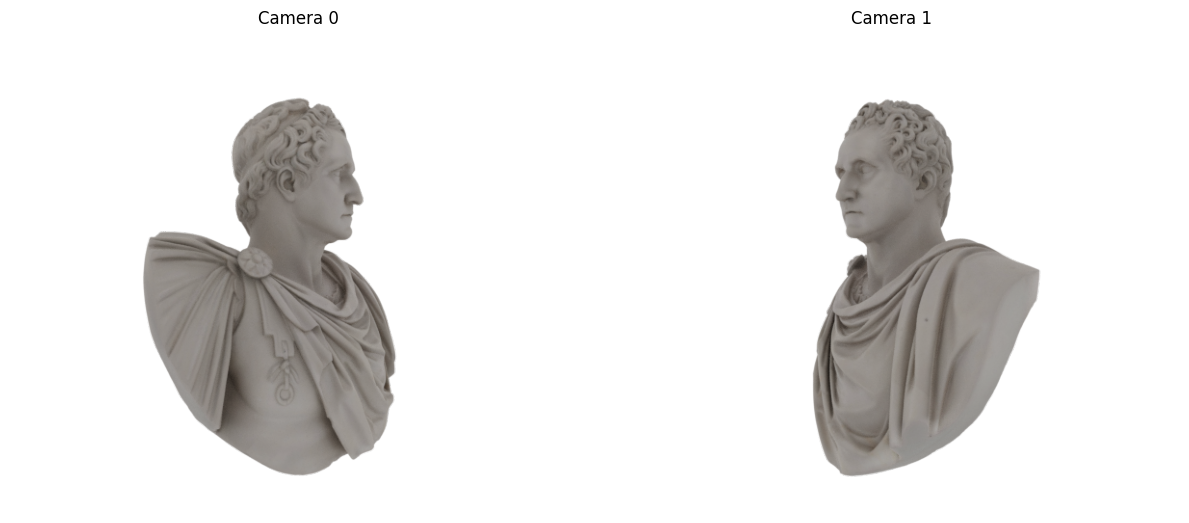

In [3]:
# Display the two camera views side by side
plt.figure(figsize=(12, 6))

# Plot first image
plt.subplot(1, 2, 1)
plt.imshow(img0)
plt.title("Camera 0")
plt.axis('off')

# Plot second image
plt.subplot(1, 2, 2)
plt.imshow(img1)
plt.title("Camera 1")
plt.axis('off')

plt.tight_layout()
plt.show()

You can also visualize the setting in 3D using `plot_epipolar_setup`. You should get an interactive 3D plot of the scene with the camera centers, camera frustrums, camera coordinate systems, and 3D mesh.

In [4]:
# pl = plot_epipolar_setup(mesh, img0, img1, scene_params)
# pl.show()

# Epipolar Geometry

### Essential Matrix and Fundamental Matrix Computation (2 Points)
Implement the function `compute_E_F` that given the scene params, computes the essential matrix $E$ and fundamental matrix $F$ from the camera intrinsics and the relative camera pose.

In [5]:
def compute_E_F(scene_params):
    """
    Takes as input the scene parameters dictionary and returns (E, F) the essential and fundamental matrix.
    """
    # dict_keys(['glob_pos0', 'glob_pos1', 'K0', 'K1', 'P0', 'P1', 'RT0', 'RT1'])

    # We need the transformation matrix which takes us from camera 1 to 0
    # Before it was easy as R1 and t1 were already these since cam 0 was aligned with world coordinates
    w_to_cam0 = np.eye(4)
    w_to_cam0[:3, :4] = scene_params['RT0']
    
    w_to_cam1 = np.eye(4)
    w_to_cam1[:3, :4] = scene_params['RT1']

    cam1_to_cam0 = w_to_cam0 @ np.linalg.inv(w_to_cam1)
    t = cam1_to_cam0[:3, 3]
    t_skew = np.array([[0, -t[2], t[1]],
                       [t[2], 0, -t[0]],
                       [-t[1], t[0], 0]])
    R = cam1_to_cam0[:3, :3]
    
    E = t_skew @ R
    F = np.linalg.inv(scene_params['K0']).T @ E @ np.linalg.inv(scene_params['K1'])
    return E, F

In [6]:
E, F = compute_E_F(scene_params)
print("Essential Matrix:\n", E)
print("Fundamental Matrix:\n", F)

Essential Matrix:
 [[-2.90456525e-23 -1.49999985e+00  1.46000962e-07]
 [-1.49999985e+00  8.49319745e-24 -8.66025085e-01]
 [ 1.46000962e-07  8.66025085e-01  3.88971571e-23]]
Fundamental Matrix:
 [[-1.81535328e-28 -9.37499909e-06  2.34375014e-03]
 [-9.37499909e-06  5.30824840e-29  6.47437014e-04]
 [ 2.34375014e-03  4.97756244e-03 -1.40625008e+00]]


Verify the epipolar constraint by taking a random 3D mesh point, computing the projections to the image planes and evaluating $u_0^T F u_1$. The results should be close to zero.

In [7]:
point_ids = np.random.randint(0, len(mesh.vertices), 10)
p3d = mesh.vertices[point_ids] # 10, 3

## Verify the epipolar constraint using the points above.
def project(proj_matrix, p3d):
    single_point = len(p3d.shape) == 1
    if single_point:
        p3d = np.hstack((p3d, 1))
    else:
        p3d = np.hstack((p3d, np.ones((p3d.shape[0], 1))))
        
    proj_matrix_full = np.eye(4)
    proj_matrix_full[:3, :4] = proj_matrix
    u = p3d @ proj_matrix_full.T
    if single_point:
        u = u[:-1] / u[-1]
    else:
        u = u[:,:-1] / u[:, -1, np.newaxis]
    return u

u0 = project(scene_params['P0'], p3d)
u1 = project(scene_params['P1'], p3d)

for i in range(10):
    print(u0[i] @ F @ u1[i].T)

-3.1326371999442464e-09
-1.0809426680020198e-08
-1.6749429618868563e-08
1.3869209946698729e-08
-3.3809376852065714e-09
7.28629522911053e-10
4.2339222387842946e-09
-8.324567837312894e-09
2.7594155945296398e-09
1.5890288332032685e-09


### Epipoles (1 Points)
Recall that the epipoles are the image points where the baseline intersects the image planes. In other words, the epipoles are the projections of the camera centers in the other image. From the lecture you know that the epipoles can be computed from the fundamental matrix. Find the epipoles in both images and plot them on the images using the function `draw_dot`.

In [8]:
## Find the epipoles e0 and e1 in image coordinates.
## The epipoles are the null vectors of the fundamental matrix and its transpose. 
# Since F is of rank 2, the last singular value will be 0 and its corresponding vectors in U and Vt the eigenvector of 0 == null vectors
U, S, Vt = np.linalg.svd(F)
# Last column vector
e0 = U[:-1, -1] / U[-1, -1]
# Last row vector
e1 = Vt[-1, :-1] / Vt[-1, -1]

print("Epipole in image 0:", e0)
print("Epipole in image 1:", e1)

Epipole in image 0: [530.94004512 250.00003893]
Epipole in image 1: [ 69.05995488 250.00003893]


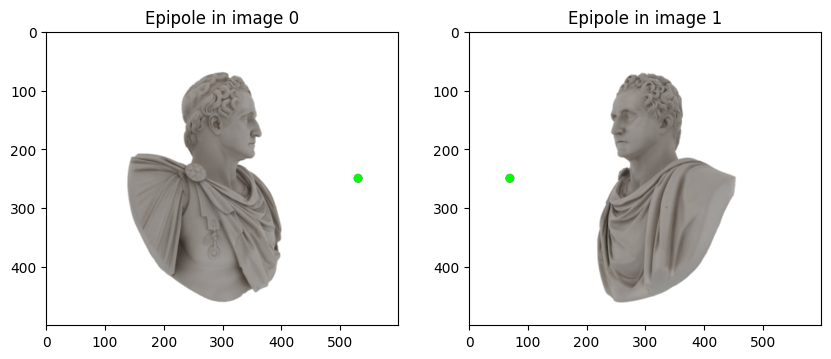

In [9]:
# Draw epipoles in green in images.
img0_ep = img0.copy()
img1_ep = img1.copy()
# Draw epipoles in images
img0_ep = draw_dot(img0_ep, e0, color=(0, 255, 0, 255), radius=7)
img1_ep = draw_dot(img1_ep, e1, color=(0, 255, 0, 255), radius=7)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img0_ep)
plt.title("Epipole in image 0")
plt.subplot(1, 2, 2)
plt.imshow(img1_ep)
plt.title("Epipole in image 1")
plt.show()

### Epipolar Lines (2 Points)

Given a 3D point, we want to find the epipolar lines in the two images.

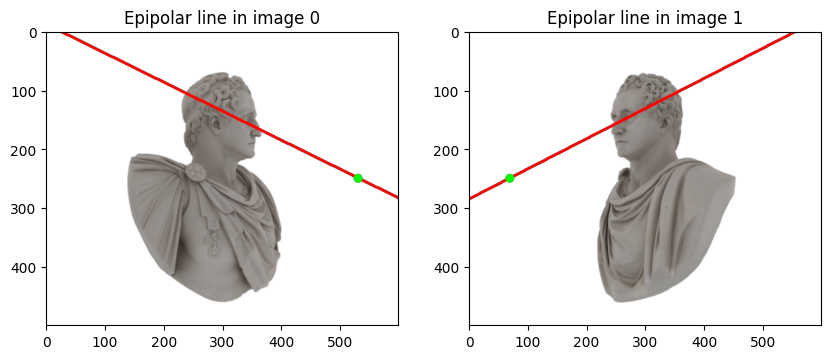

In [10]:
PID = 20405 # 100 Point ID. Try: 354 (nose), 21926 (medal), 20405 (hair)
point = mesh.vertices[PID]

# Find the epipolar lines in both images for the 3D point point.
l0 = F@project(scene_params['P0'], point)
l1 = project(scene_params['P1'], point).T@F

# Draw epipolar lines in images
img0_line = img0.copy()
img1_line = img1.copy()
img0_line = draw_line(img0_line, l0, color=(255, 0, 0, 255))
img1_line = draw_line(img1_line, l1, color=(255, 0, 0, 255))
img0_line = draw_dot(img0_line, e0, color=(0, 255, 0, 255), radius=7)
img1_line = draw_dot(img1_line, e1, color=(0, 255, 0, 255), radius=7)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img0_line)
plt.title("Epipolar line in image 0")
plt.subplot(1, 2, 2)
plt.imshow(img1_line)
plt.title("Epipolar line in image 1")
plt.show()

# Estimating Relative Pose of Two Cameras From 2D-2D Correspondences

In this exercise we will implement the normalized 8-point algorithm to estimate the fundamental matrix from 2D-2D point correspondences. Then we will decompose the essential matrix to estimate the relative pose of the two cameras. Finally, we will triangulate the 3D points from the 2D-2D correspondences and the estimated relative pose.

## Correspondences
We will use SuperPoint and SuperGlue for feature extraction and matching. Note that these correspondence matching algorithms are not perfect and will produce outliers. So if you observe inaccurate results, it can be due to bad correspondences. Below we provide a quick and dirty way of computing perfect correspondences via projection. We advise you to use this for debugging your code, to eliminate the effect of bad correspondences. 

In [11]:
# Feel free to try other scenes (not "01", because there are not enough matches)
scene_params, img0, img1 = load_scene_params2(scene_id="06")

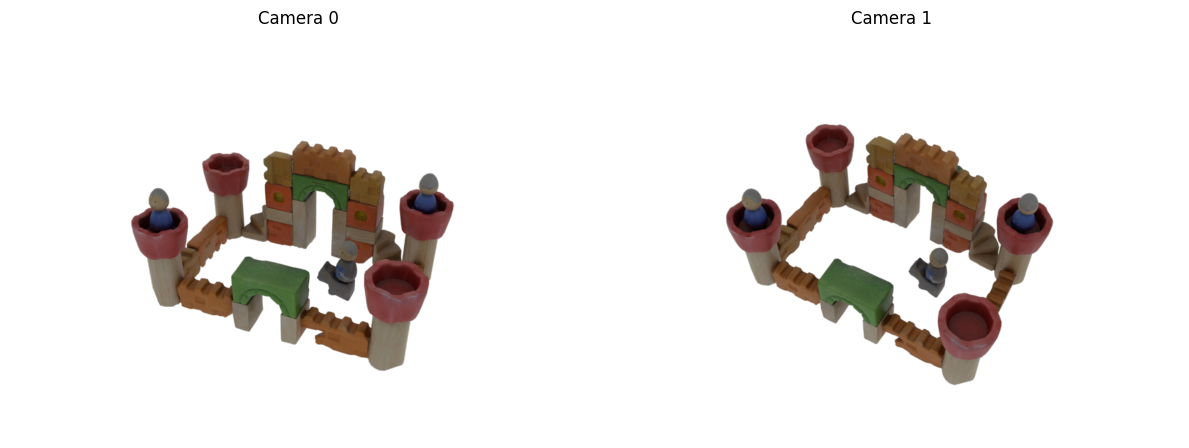

In [12]:
# Display the two camera views side by side
plt.figure(figsize=(12, 6))

# Plot first image
plt.subplot(1, 2, 1)
plt.imshow(img0)
plt.title("Camera 0")
plt.axis('off')

# Plot second image
plt.subplot(1, 2, 2)
plt.imshow(img1)
plt.title("Camera 1")
plt.axis('off')

plt.tight_layout()
plt.show()

In [13]:
points0, points1 = superglue_correspondences(img0, img1, kth=0.001, mth=0.5)

2025-05-25 15:52:59.716 | INFO     | superpoint_superglue_deployment.superpoint_handler:__init__:58 - loaded superpoint weights superpoint_v1.pth
2025-05-25 15:52:59.794 | INFO     | superpoint_superglue_deployment.superglue_handler:__init__:67 - loaded superglue weights superglue_outdoor.pth


In [14]:
##############################
# Uncomment the following codeblock if you want to use perfect correspondences, computed from the ground truth 3D 
# mesh, instead of the correspondences found by superpoint and superglue. 
# This includes also matches which cannot be visible on both images, as they are on the back side of the object etc.
# You can use this to test your reconstruction code.
##############################

# ONLY POSSIBLE FOR SCAN 1

# SAMPLES = 10000
# p3d = np.random.randint(0, len(mesh.vertices), SAMPLES)
# p3d = mesh.vertices[p3d]
# p3d_hom = np.hstack([p3d, np.ones((SAMPLES, 1))])
# P0 = scene_params["P0"] # camera 0 projection matrix
# P1 = scene_params["P1"] # camera 1 projection matrix
# p2d_hom0 = p3d_hom @ P0.T
# p2d_hom1 = p3d_hom @ P1.T
# points0 = p2d_hom0[:, :2] / p2d_hom0[:, 2][:, None]
# points1 = p2d_hom1[:, :2] / p2d_hom1[:, 2][:, None]

Let us visualize the 2D-2D correspondences below.

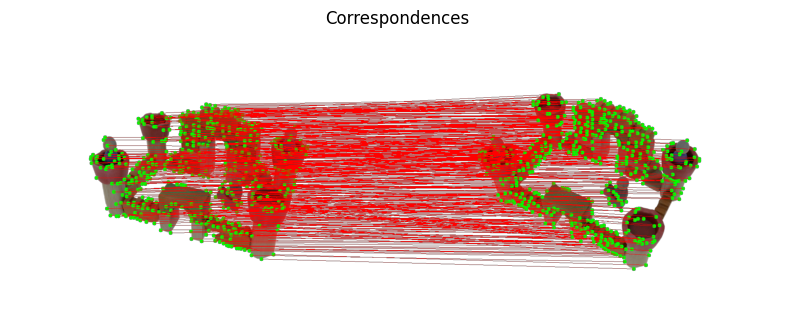

In [15]:
matched_image = draw_matches(img0, img1, points0, points1)
plt.figure(figsize=(10, 5))
plt.imshow(matched_image)
plt.title("Correspondences")
plt.axis("off")
plt.show()

## Normalized 8-Point Algorithm (10 Points)

Next we implement the normalized 8-point algorithm to estimate the fundamental matrix from the 2D-2D correspondences.
For this we first have to normalize the points such that their centroid (mean) is at the origin and the average distance to the origin is around $\sqrt{2}$.
Implement the function `normalize_points` that takes a set of 2D points and returns the normalized points and the transformation matrix $\mathbf{T}$ that was used to normalize the points.

In [16]:
def normalize_points(points):
    """
    Normalize 2D points for improved numerical stability.
    
    Parameters:
        points (np.ndarray): 2D points, shape (n, 2)
        
    Returns:
        normalized_points (np.ndarray): Normalized points, shape (n, 2)
        T (np.ndarray): Transformation matrix, shape (3, 3)
    """
    points_mean = np.mean(points, axis=0)
    T_center = np.eye(3)
    T_center[:-1, 2] = -points_mean

    points_cent = points - points_mean
    avg_dist = np.mean(np.linalg.norm(points_cent, axis=1))
    T_scale = np.eye(3)
    T_scale[:-1, :-1] = np.sqrt(2)/avg_dist * np.eye(2)

    T = T_scale @ T_center
    points_homog = np.hstack((points, np.ones((points.shape[0], 1))))
    norm_points = points_homog@T.T

    return norm_points, T

You can test your function by calling the function `test_normalize_points`. It will show the original 2D image points and the normalized image points next to each other. The normalized points should be centered around the origin and have an average distance of $\sqrt{2}$, while keeping the same relative structure.

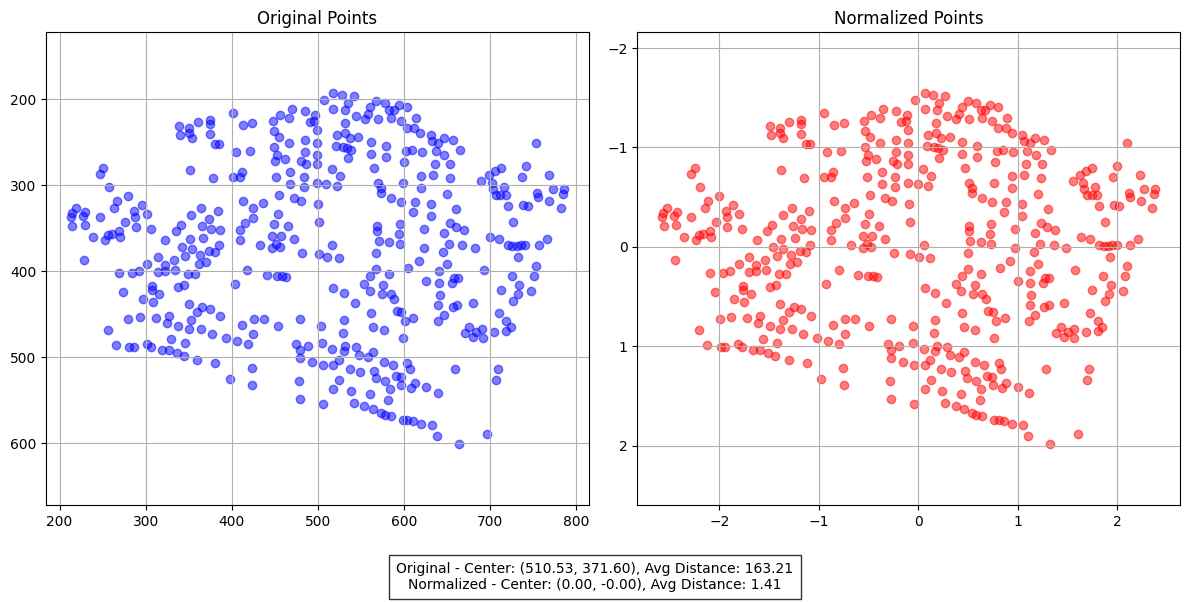

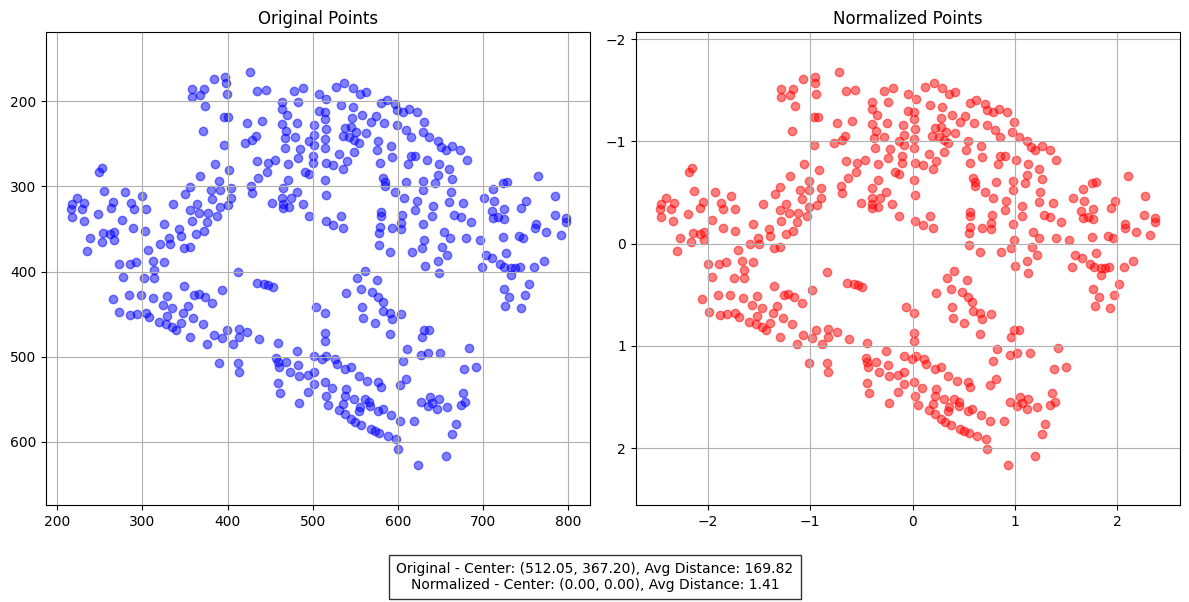

In [17]:
norm_points0, T0 = normalize_points(points0)
norm_points1, T1 = normalize_points(points1)

test_normalize_points(points0, norm_points0)
test_normalize_points(points1, norm_points1)

Next, implement the normalized 8-point algorithm in the function `eight_point`. The function should take the original image points, and return the estimated fundamental matrix $\mathbf{F}$. Make sure to make use of the normalization function you implemented before. Also make sure to enforce the rank-2 constraint on the fundamental matrix.

In [18]:
def eight_point(p0, p1):
    """
    Normalized 8-point algorithm for fundamental matrix estimation.
    
    Parameters:
        p0 (np.ndarray): Points in image 0, shape (n, 2) where n >= 8
        p1 (np.ndarray): Corresponding points in image 1, shape (n, 2) where n >= 8
        
    Returns:
        F (np.ndarray): Fundamental matrix of shape (3, 3)
    """
    n = p0.shape[0]
    norm_p0, T0 = normalize_points(p0)
    norm_p1, T1 = normalize_points(p1)

    x0, y0 = norm_p0[:,0], norm_p0[:,1]
    x1, y1 = norm_p1[:,0], norm_p1[:,1]
    W = np.column_stack([x0*x1, x0*y1, x0, y0*x1, y0*y1, y0, x1, y1, np.ones(n)])

    U, Sigma, Vt = np.linalg.svd(W)
    F_hat = Vt[-1].reshape((3,3))
    
    U, Sigma, Vt = np.linalg.svd(F_hat)
    F = U @ np.diag([Sigma[0], Sigma[1], 0]) @ Vt

    return T0.T@F@T1

F = eight_point(points0, points1)

Let us estimate the fundamental matrix from the correspondences, and compare the epipoles and epipolar lines with the ground-truth values.

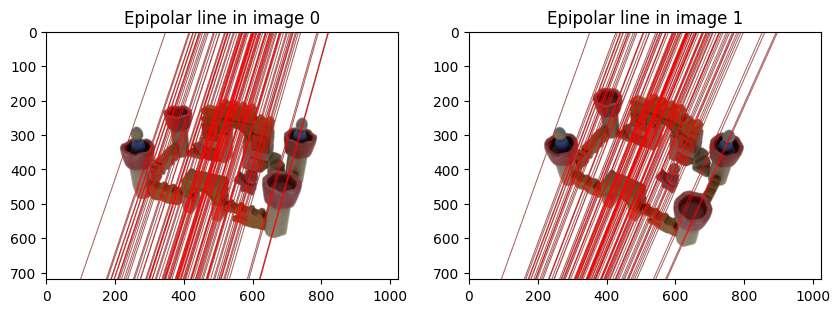

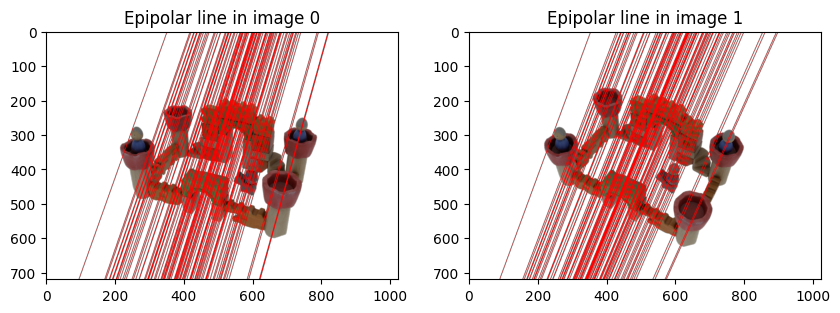

[[-8.25365874e-06  1.08854962e-05 -8.09796613e-02]
 [ 8.07282200e-06  7.65090882e-06 -3.16969451e-02]
 [ 7.99925233e-02  2.38275003e-02  9.92708942e-01]] 
 [[-6.47057271e-06  7.78617126e-06 -6.35996232e-02]
 [ 7.78617842e-06  6.47057169e-06 -2.61924530e-02]
 [ 6.25198310e-02  1.93721930e-02  9.95482311e-01]]


In [19]:
def draw_epipolar_lines(img0, points0, img1, points1, F):
    epiline_img0 = img0.copy()
    epiline_img1 = img1.copy()
    U, S, Vt = np.linalg.svd(F)
    epi0 = U[:, 2]
    epi0 /= epi0[2]
    epi1 = Vt[-1]
    epi1 /= epi1[2]
    for i in range(len(points0)):
        l0 = F @ np.hstack([points1[i], 1])
        l1 = F.T @ np.hstack([points0[i], 1])
        epiline_img0 = draw_line(epiline_img0, l0, color=(255, 0, 0, 255), width=2)
        epiline_img1 = draw_line(epiline_img1, l1, color=(255, 0, 0, 255), width=2)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(epiline_img0)
    plt.title("Epipolar line in image 0")
    plt.subplot(1, 2, 2)
    plt.imshow(epiline_img1)
    plt.title("Epipolar line in image 1")
    plt.show()

num_lines = 100
draw_epipolar_lines(img0, points0[:num_lines], img1, points1[:num_lines], F)

# Ground truth comparison
E_gt, F_gt = compute_E_F(scene_params)
draw_epipolar_lines(img0, points0[:num_lines], img1, points1[:num_lines], F_gt)
print(F/np.linalg.norm(F), '\n', F_gt/np.linalg.norm(F_gt))

What are the estimated epipoles? What are the real epipoles?

In [20]:
U, S, Vt = np.linalg.svd(F)
# Last column vector
e0 = U[:-1, -1] / U[-1, -1]
# Last row vector
e1 = Vt[-1, :-1] / Vt[-1, -1]
print(" - Estimated epipole in image 0:", e0)
print(" - Estimated epipole in image 1:", e1)

U, S, Vt = np.linalg.svd(F_gt)
# Last column vector
e0 = U[:-1, -1] / U[-1, -1]
# Last row vector
e1 = Vt[-1, :-1] / Vt[-1, -1]
print(" - Actual epipole in image 0:", e0)
print(" - Actual epipole in image 1:", e1)

 - Estimated epipole in image 0: [ 2778.75363386 -7067.86785228]
 - Estimated epipole in image 1: [-1817.78936861  6060.93160791]
 - Actual epipole in image 0: [ 2475.33133357 -5972.50886422]
 - Actual epipole in image 1: [-2025.38079564  6485.11928806]


Finally, compute the estimate for the essential matrix $\mathbf{E}$ from the fundamental matrix $\mathbf{F}$ and the camera intrinsics $\mathbf{K}_1$ and $\mathbf{K}_2$. The $\mathbf{K}_i$ are part of the scene parameters.

In [21]:
E = scene_params['K0'].T @ F @ scene_params['K1']
print(E/np.linalg.norm(E), '\n', E_gt/np.linalg.norm(E_gt))

[[-6.79440269e-02  8.96092839e-02 -6.69151671e-01]
 [ 6.64553809e-02  6.29821963e-02 -2.04230154e-01]
 [ 6.47634158e-01  2.64701261e-01 -1.92611534e-04]] 
 [[-6.74047095e-02  8.11094528e-02 -6.67836490e-01]
 [ 8.11095274e-02  6.74046988e-02 -2.07056064e-01]
 [ 6.45964579e-01  2.67596123e-01 -5.28120571e-08]]


## Recovering Relative Pose (5 Points)
From the lecture you know that from the essential matrix $E$ we can recover the relative pose of the cameras. There are four possible solutions for the relative pose, but in only one of them, the scene is in front of both cameras. Implement the function `recover_relative_pose` that takes the essential matrix and returns the four possible relative poses.

In [22]:
def pose_candidates(E):
    """
    Compute the four possible camera poses from the essential matrix.
    
    Parameters:
        E (np.ndarray): Essential matrix of shape (3, 3)
        
    Returns:
        Candidates (list): List of 4 possible camera poses, each represented as a list [R, t]
    """
    W = np.array([[0,-1,0],[1,0,0],[0,0,1]])
    U, Sigma, Vt = np.linalg.svd(E)
    scale = Sigma[0]
    U, Sigma, Vt = np.linalg.svd(E/scale)

    u3s = [U[:, -1], -U[:, -1]]
    Rs = [U@W@Vt, U@W.T@Vt]
    candidates = [[R, u3] for u3 in u3s for R in Rs]
    return candidates

candidates = pose_candidates(E)

We can visualize the relative poses by drawing the camera frustums using `draw_candidates`. Note that each frustum has a little triangle on top pointing upwards in image frame! One of the candidates should be oriented corretly relatively to the camera 0.
Hint for the viewer: You can use Ctrl + Left Click to rotate the viewer's camera around it's viewing axis.

In [23]:
# draw_candidates(candidates)

We know that that the correct relative pose is among these four candidates. To find the best one, we can triangulate the 3D points from the 2D-2D correspondences, and check which configuration gives us the most points in front of both cameras. Implement the function `find_best_candidate` that takes the candidates, 2D-2D correspondences and the scene params as input and returns the best candidate, as well as the triangulated 3D points. 
You can use `cv2.triangulatePoints` for this.

In [24]:
def find_best_candidate(candidates, points0, points1, scene_params):
    """
    Find the best candidate pose by triangulating points and counting the number of points in front of both cameras.
    Parameters:
        candidates (list): List of candidate poses for camera 1
        points0 (np.ndarray): Points in image 0, shape (n, 2)
        points1 (np.ndarray): Points in image 1, shape (n, 2)
        scene_params (dict): Scene parameters including camera 0 intrinsics and extrinsics and camera 1 intrinsics
    Returns:
        best_candidate (tuple): Best candidate pose (R, t)
        estimated_point_cloud (np.ndarray): Estimated 3D point cloud, shape (n, 3)
    """
    # Camera 0 is aligned with the world coordinates according to draw_candidates function
    intrinsics_0 = np.eye(4)
    intrinsics_0[:3, :3] = scene_params['K0']
    P0 = intrinsics_0 @ np.eye(4)

    intrinsics_1 = np.eye(4)
    intrinsics_1[:3, :3] = scene_params['K1']

    best_candidate = None
    estimated_point_cloud = None
    most_points = -1
    for i, candidate in enumerate(candidates):
        R, t = candidate
        extrinsics = np.eye(4)
        extrinsics[:3, :3] = R
        extrinsics[:3, 3] = t
        P1 = intrinsics_1 @ extrinsics

        points3d_world = cv2.triangulatePoints(P0[:-1], P1[:-1], points0.T, points1.T).T
        points3d_world = points3d_world / points3d_world[:,-1, np.newaxis]

        points_infront_cam0 = points3d_world[:, 2] > 0
        points3d_cam1 = points3d_world @ extrinsics.T
        points_infront_cam1 = points3d_cam1[:, 2] > 0
        num_points_both_cams = sum(points_infront_cam0) + sum(points_infront_cam1)
        
        if num_points_both_cams > most_points:
            best_candidate = candidate
            estimated_point_cloud = points3d_world
            most_points = num_points_both_cams
    
    return best_candidate, estimated_point_cloud[:,:-1]

best_candidate, estimated_point_cloud = find_best_candidate(candidates, points0, points1, scene_params)

Finally, let us plot the estimated relative camera poses together with the triangulated 3D points. Use the function `draw_pair_with_reconstruction` which takes as input:
- $\mathbf{K}_0$,
- $\mathbf{K}_1$,
- the extrinsic parameters of camera 1 (recall that we assume that camera 0's frame = world frame),
- the two images (for sizes of image planes and colors),
- 2D points in image 0 and 1, to extract color information,
- the triangulated 3D points.

You only have to pass the correct arguments to the function. The function will plot the two images with the triangulated 3D points and the camera frustums.

In [25]:
# TODO: Compute the extrinsic matrix RT
R, t = best_candidate
RT = np.hstack((R, t[:, np.newaxis]))

draw_pair_with_reconstruction(scene_params["K0"], 
                              scene_params["K1"], 
                              RT, 
                              img0, 
                              img1, 
                              points0, 
                              points1, 
                              estimated_point_cloud, 
                              size=15)

libGL error: MESA-LOADER: failed to open radeonsi: /usr/lib/dri/radeonsi_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: radeonsi
libGL error: MESA-LOADER: failed to open radeonsi: /usr/lib/dri/radeonsi_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: radeonsi
libGL error: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: swrast
libGL error: MESA-LOADER: failed to open radeonsi: /usr/lib/dri/radeonsi_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN

Widget(value='<iframe src="http://localhost:34387/index.html?ui=P_0x7ca41872dd30_0&reconnect=auto" class="pyvi…